In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

from glob import glob
import random
from PIL import Image
import numpy as np

# Dataset

In [31]:
class GAN_CustomDataset(Dataset):
    def __init__(self, data_paths,transform=None,output_path=True):
        self.data_path_monet, self.data_path_photo = self.get_all_path(data_paths)
        self.transform = transform
        self.output_path = output_path

    def __len__(self):
        return len(self.data_path_photo)
    

    def __getitem__(self, idx):
        sample_monet_paths = self.data_path_monet[idx]
        sample_photo_paths = self.data_path_photo[idx]
    
        sample_monet = []
        sample_photo = []
        if self.output_path == True:
            sample_monet = sample_monet_paths
            sample_photo = sample_photo_paths
            
        elif self.output_path == False:
           
            img_monet = Image.open(sample_monet_paths).convert('RGB') # (height, width, channels)
            img_monet = self.transform(img_monet)
            sample_monet = img_monet

            img_photo = Image.open(sample_photo_paths).convert('RGB') # (height, width, channels)
            img_photo = self.transform(img_photo)
            sample_photo = img_photo

            # Convert list of images to tensor
            sample_monet = torch.tensor(sample_monet)
            sample_photo = torch.tensor(sample_photo) 

        return sample_monet, sample_photo
    
    def get_all_path(self,data_paths):
        path_monet = [i for i in glob(data_paths[0])]
        path_photo = [i for i in glob(data_paths[1])]
        
        # Oversampling
        size_difference = np.abs(len(path_monet) - len(path_photo))
        path_monet += random.choices(path_monet, k=size_difference)
        
        return path_monet, path_photo

In [32]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ConvertImageDtype(torch.float)
])

## Visual

In [33]:
dataset = GAN_CustomDataset(data_paths=['gan-getting-started/monet_jpg/*',
                                    'gan-getting-started/photo_jpg/*'],
                        transform=transform)

In [34]:
def plot_im(data):
    # Number of image pairs
    monet_paths = data[0]
    photo_paths = data[1]
    num_images = min(len(monet_paths), len(photo_paths))

    # Create a plot with `num_images` rows and 2 columns (one for Monet and one for Photo)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

    # Loop through each pair of images
    for i in range(num_images):
        # Load and display the Monet image
        monet_img = Image.open(monet_paths[i]).convert('RGB')
        axes[i, 0].imshow(monet_img)
        axes[i, 0].axis('off')  # Hide axes
        axes[i, 0].set_title("Monet")

        # Load and display the Photo image
        photo_img = Image.open(photo_paths[i]).convert('RGB')
        axes[i, 1].imshow(photo_img)
        axes[i, 1].axis('off')  # Hide axes
        axes[i, 1].set_title("Photo")
     
    # Display the plot
    plt.tight_layout()
    plt.show()


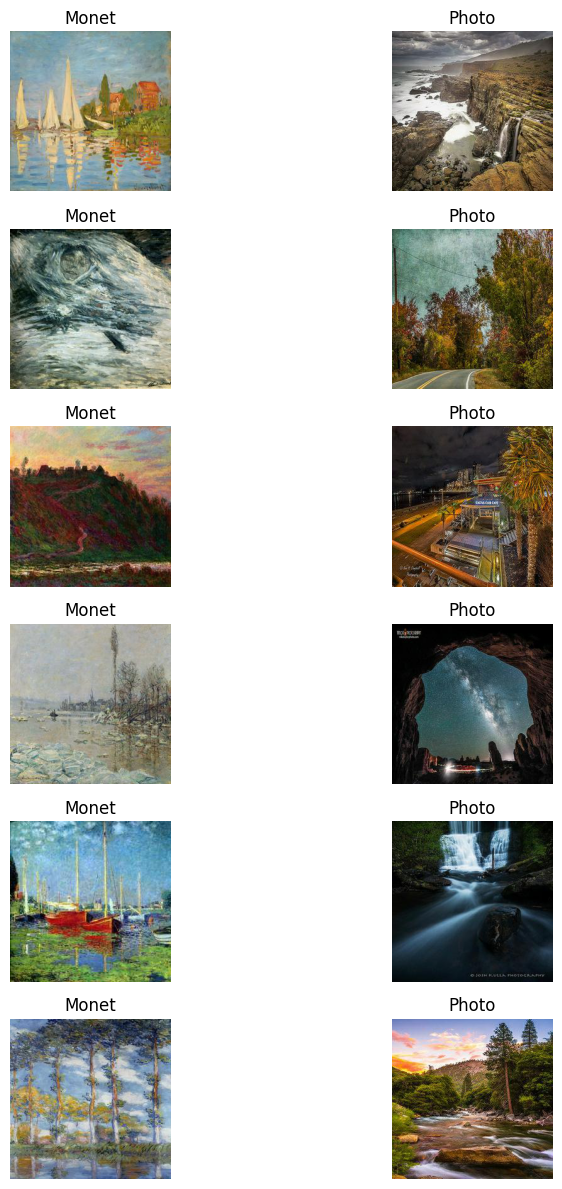

In [35]:
plot_im(dataset[:6])

## Create

In [36]:
dataset = GAN_CustomDataset(data_paths=['gan-getting-started/monet_jpg/*',
                                    'gan-getting-started/photo_jpg/*'],
                        transform=transform,
                        output_path=False)
dataloader = DataLoader(dataset, batch_size=32 , shuffle=True)

In [37]:
len(dataloader)

220

# Models

## Generator

In [38]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [40]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [41]:
gen = Generator(in_channels=3, out_channels=3)
m,p = dataset[0]
x = gen.forward(m.unsqueeze(0))

/var/folders/9q/gllpszsd7tx204064mvtm3540000gn/T/ipykernel_3001/2603122560.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_monet = torch.tensor(sample_monet)
/var/folders/9q/gllpszsd7tx204064mvtm3540000gn/T/ipykernel_3001/2603122560.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_photo = torch.tensor(sample_photo)


## Discriminator

In [42]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )

        self.liners = nn.Sequential(
            nn.Linear(8 * 28 * 28, 10000),
            nn.ReLU(inplace=True),
            nn.Linear(10000,500),
            nn.ReLU(inplace=True),
            nn.Linear(500,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.liners(x)

        return x

In [43]:
dis = Discriminator(in_channels=3)
x = dis(x)

In [44]:
x.view(-1)

tensor([0.5201], grad_fn=<ViewBackward0>)

# Training

In [45]:
eporchs = 1
lr = 0.001

GenX_y = Generator(in_channels=3, out_channels=3).to(device)
Geny_X = Generator(in_channels=3, out_channels=3).to(device)

discriminator = Discriminator(in_channels=3).to(device)


opti_gen = optim.Adam(list(GenX_y.parameters()) + list(Geny_X.parameters()), lr=lr)
opti_dis = optim.Adam(discriminator.parameters(), lr=lr)

criterion_GAN = nn.BCELoss()
criterion_cycle = nn.MSELoss()

'''
monet_X --> GenX_y --> photo_y --> Geny_X --> monet_y
                        |
                        V
                    discriminator
                        |
                        V
                        T/F

'''

'''
LOSS UPDATE
GenX_y = monet_y & monet_X # mse loss


'''

'\nLOSS UPDATE\nGenX_y = monet_y & monet_X # mse loss\n\n\n'

In [46]:
def save_checkpoint(model, optimizer, Iteration, path="model_checkpoint.pth"):
    checkpoint = {
        'Iteration': Iteration,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

In [47]:
epochs = 1

for epoch in range(epochs):
    Iteration = 1
    train_dataloader = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for (monet_images, photo_images) in tqdm(train_dataloader):
        
        # ===========================
        # Train Discriminator
        # ===========================
        photo_images = photo_images.to(device)
        monet_images = monet_images.to(device)
        
        # Generate Fake Monet and Cycle Back
        gen_monet = GenX_y(photo_images)
        gen_photo = Geny_X(gen_monet)

        # Discriminator on Fake/Real
        dis_fake = discriminator(gen_monet.detach())  # Detach to avoid gradient on G
        lossD_fake = criterion_GAN(dis_fake.view(-1), torch.zeros_like(dis_fake).view(-1)) # D(fake)

        dis_real = discriminator(monet_images)
        lossD_real = criterion_GAN(dis_real.view(-1), torch.ones_like(dis_real).view(-1)) # D(real)

        # Total Discriminator Loss
        loss_D = (lossD_real + lossD_fake) / 2 

        # Optimize Discriminator
        discriminator.zero_grad()
        loss_D.backward()
        opti_dis.step()

        # ===========================
        # Train Generator
        # ===========================
        gen_monet = GenX_y(photo_images)  # Generate again for accurate gradients
        gen_photo = Geny_X(gen_monet)

        # Adversarial Loss for G
        dis_fake = discriminator(gen_monet)
        loss_GAN = criterion_GAN(dis_fake.view(-1), torch.ones_like(dis_fake).view(-1))  # Fool D

        # Cycle Consistency Loss
        loss_cycle = criterion_cycle(gen_photo, photo_images)

        # Total Generator Loss
        loss_G = loss_GAN + loss_cycle
        
        # Optimize Generator
        opti_gen.zero_grad()
        loss_G.backward()
        opti_gen.step()

        if Iteration % 5 == 0:
            print(f"Iteration: {Iteration + 1}, loss_D: {loss_D.item()}, loss_G: {loss_G.item()}")
            
        Iteration +=1
        
torch.save(GenX_y.to('cpu').state_dict(), "generator.pth")


Epoch 1/1:   0%|          | 0/220 [00:00<?, ?it/s]/var/folders/9q/gllpszsd7tx204064mvtm3540000gn/T/ipykernel_3001/2603122560.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_monet = torch.tensor(sample_monet)
/var/folders/9q/gllpszsd7tx204064mvtm3540000gn/T/ipykernel_3001/2603122560.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_photo = torch.tensor(sample_photo)
  0%|          | 1/220 [00:51<3:09:05, 51.81s/it]


KeyboardInterrupt: 